In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas import Series
import requests
import json

In [85]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

# Adding weighted price

hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4

In [12]:
hist.head()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2013-11-25,829.99,849.99,758.95,795.01,26381.41,21438670.96,808.4850
2013-11-26,969.96,974.96,825.08,829.99,31613.86,28285852.13,899.9975
2013-11-27,1079.89,1094.78,914.27,969.96,37859.08,37868643.04,1014.7250
2013-11-28,1101.38,1224.48,1032.06,1079.89,37396.83,42912383.44,1109.4525
2013-11-29,1206.93,1241.92,1049.96,1101.38,38706.56,45030632.96,1150.0475


In [13]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [14]:
train, test = train_test_split(hist, test_size=0.1)

In [15]:
train_original = train.copy()
test_original = test.copy()

# ARIMA model

In [86]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    #rolmean = pd.rolling_mean(timeseries,window = 24)
    #rolstd = pd.rolling_std(timeseries, window = 24)
    rolmean = timeseries.rolling(window= 24).mean()
    rolstd = timeseries.rolling(window= 24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

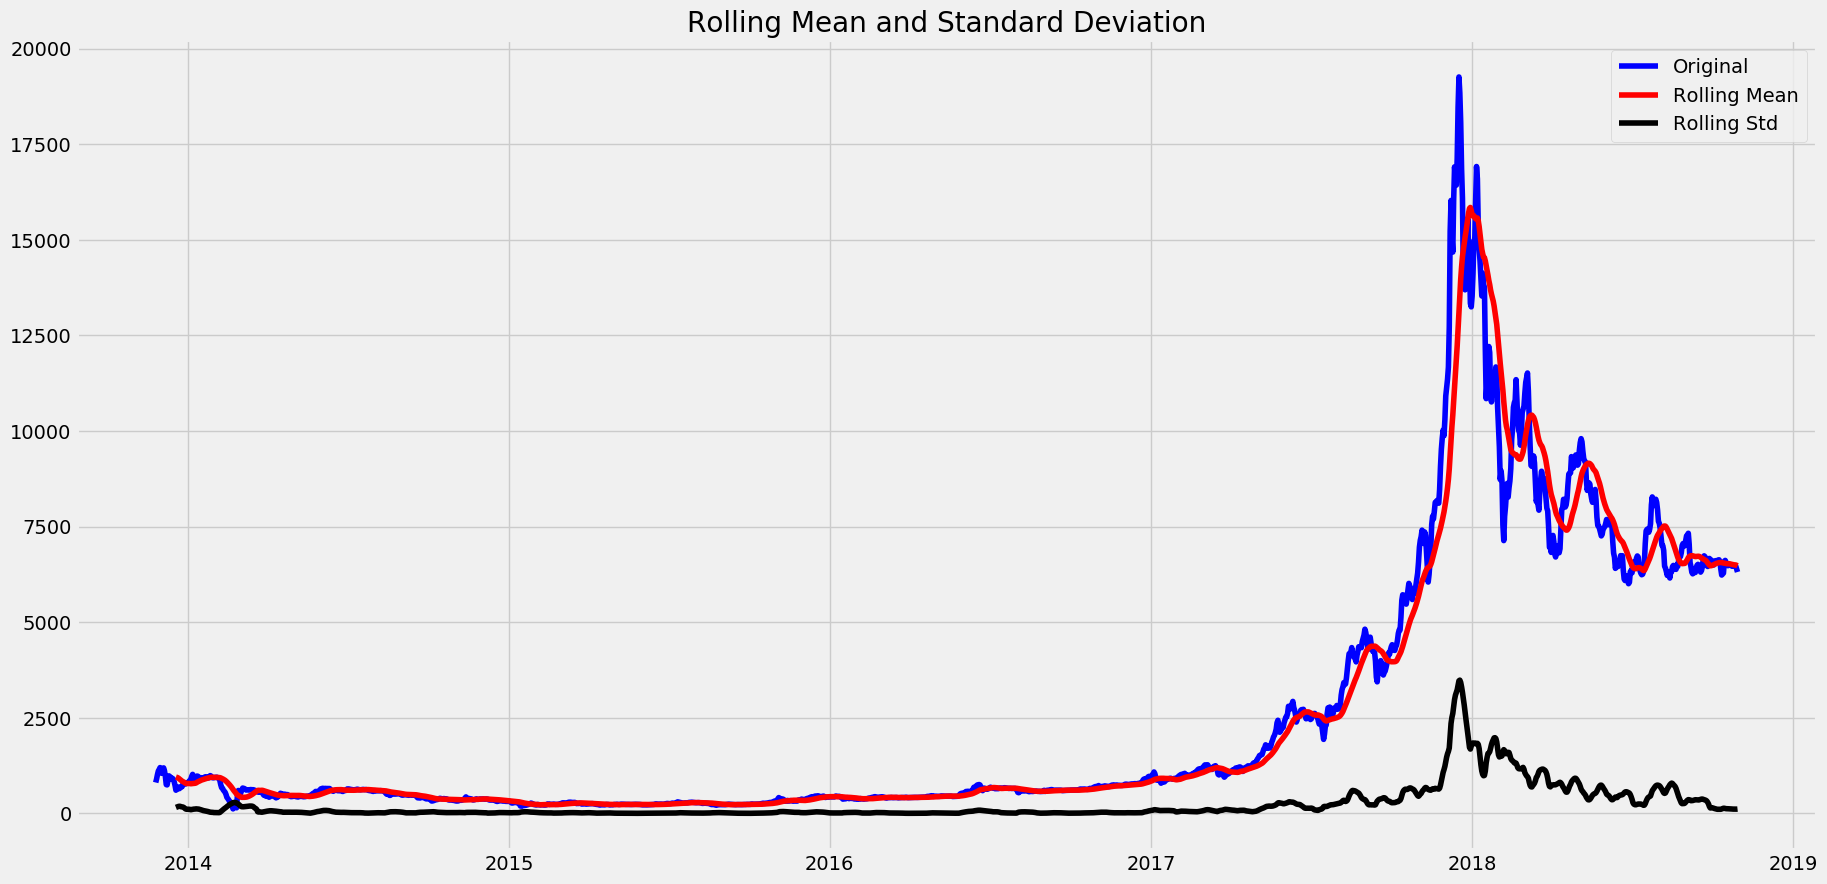

Results of Dickey Fuller test: 
Test Statistics                  -1.816720
p-value                           0.372193
# Lag Used                       25.000000
Number of Observations Used    1775.000000
Critical Value (1%)              -3.434039
Critical Value (5%)              -2.863170
Critical Value (10%)             -2.567638
dtype: float64


In [87]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(20,10)
test_stationary(train_original['Weighted_Price'])

In [88]:
Train = train.ix['2013-11-25':'2015-06-24']
valid = train.ix['2015-06-25':'2016-09-25']

/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [89]:
Train_log = np.log(Train['Weighted_Price'])
valid_log = np.log(valid['Weighted_Price'])

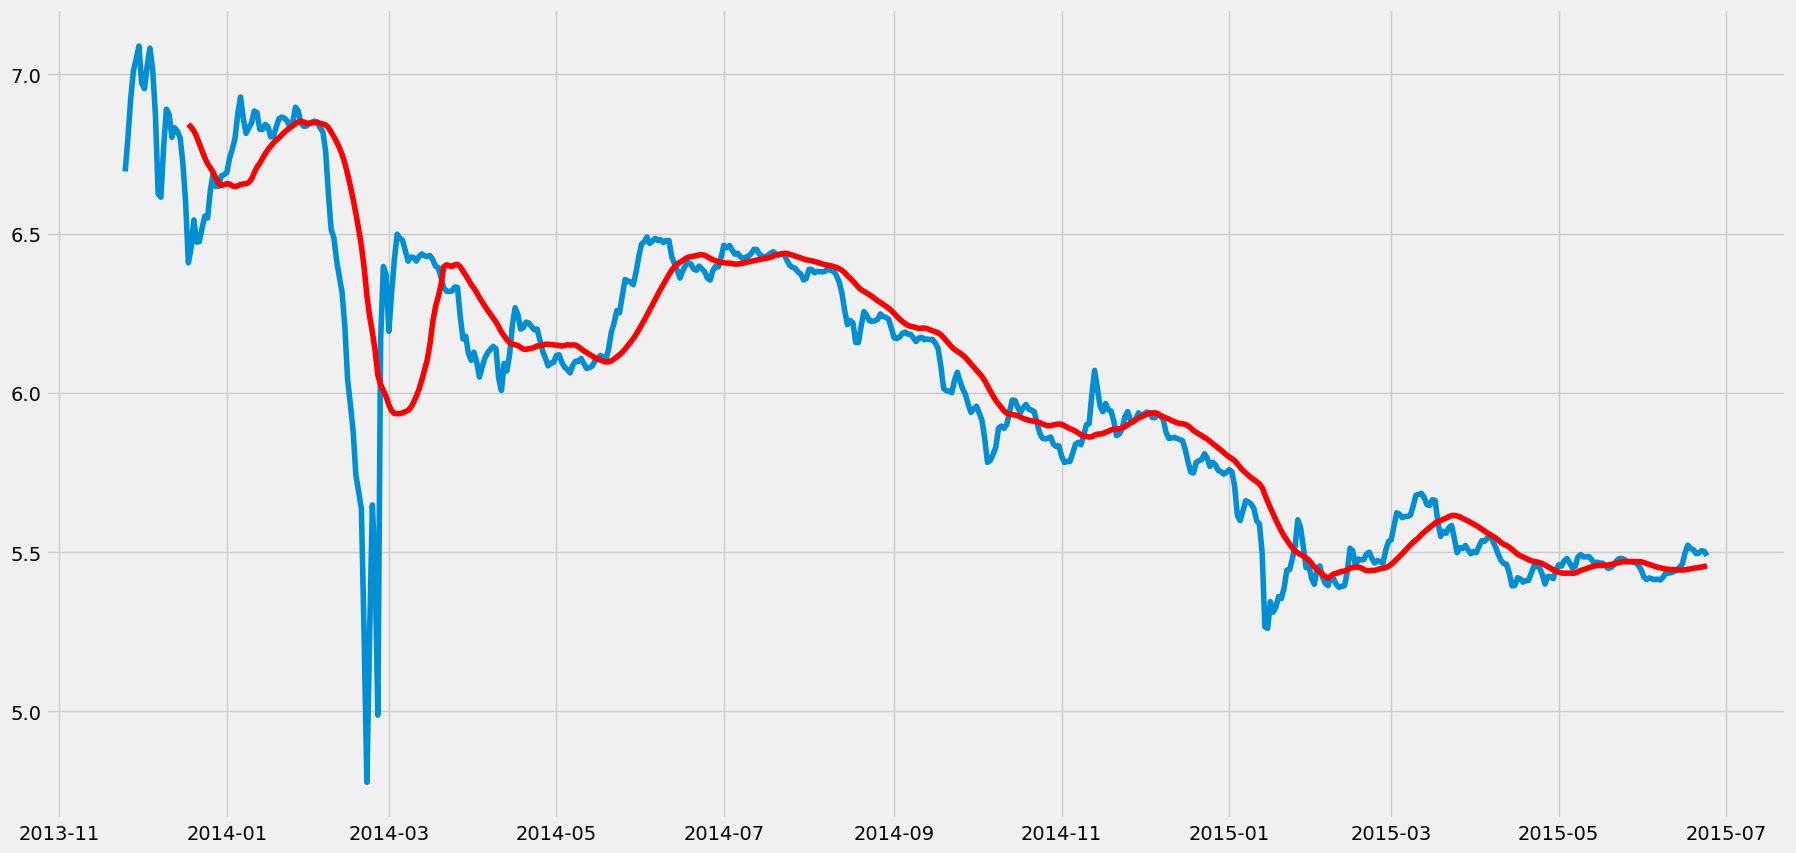

In [90]:
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')

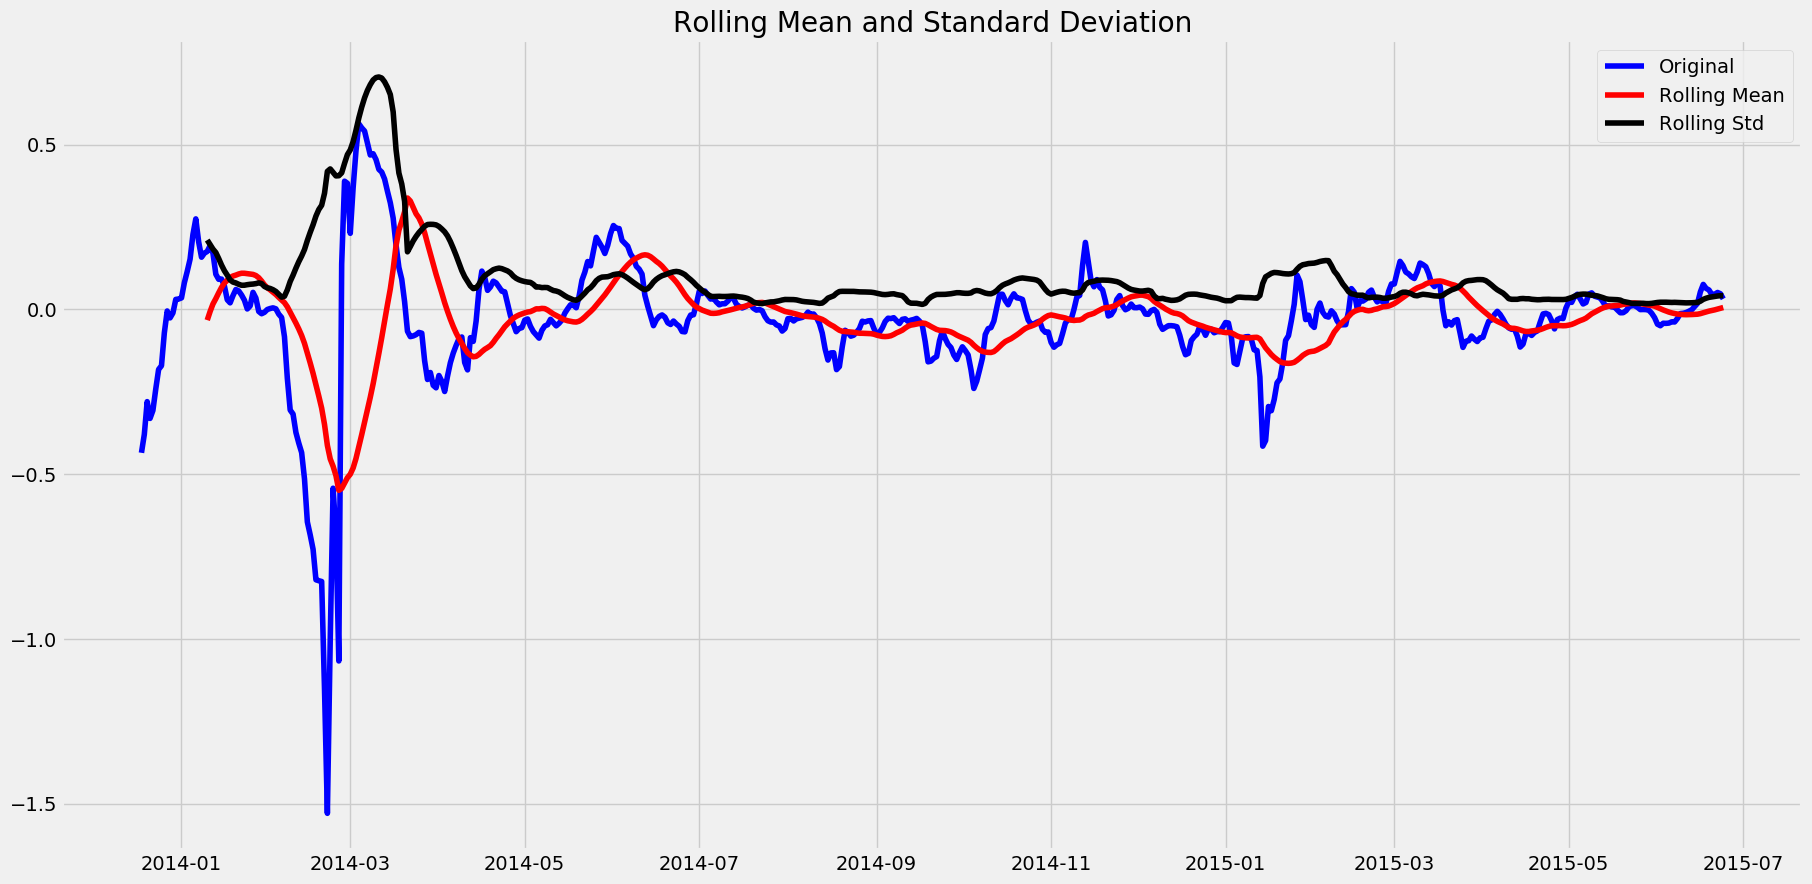

Results of Dickey Fuller test: 
Test Statistics               -6.681061e+00
p-value                        4.341122e-09
# Lag Used                     1.100000e+01
Number of Observations Used    5.420000e+02
Critical Value (1%)           -3.442473e+00
Critical Value (5%)           -2.866887e+00
Critical Value (10%)          -2.569618e+00
dtype: float64


In [91]:
train_log_moving_diff = Train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)
test_stationary(train_log_moving_diff)

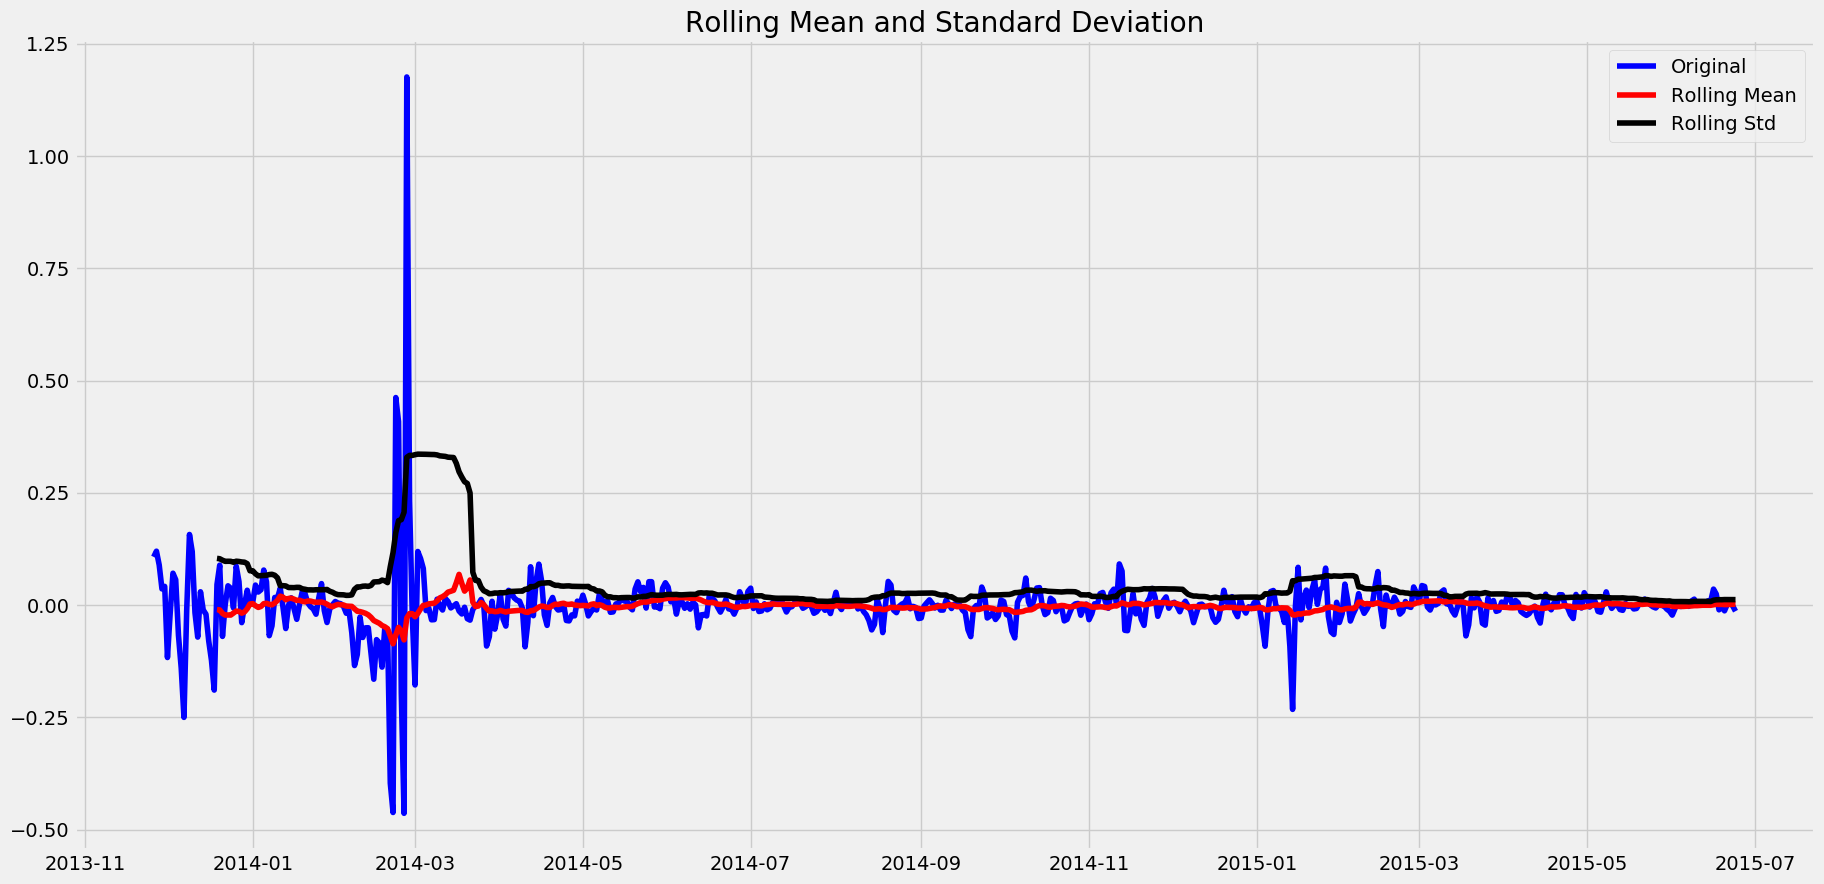

Results of Dickey Fuller test: 
Test Statistics               -9.127425e+00
p-value                        3.086564e-15
# Lag Used                     7.000000e+00
Number of Observations Used    5.680000e+02
Critical Value (1%)           -3.441915e+00
Critical Value (5%)           -2.866642e+00
Critical Value (10%)          -2.569487e+00
dtype: float64


In [92]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

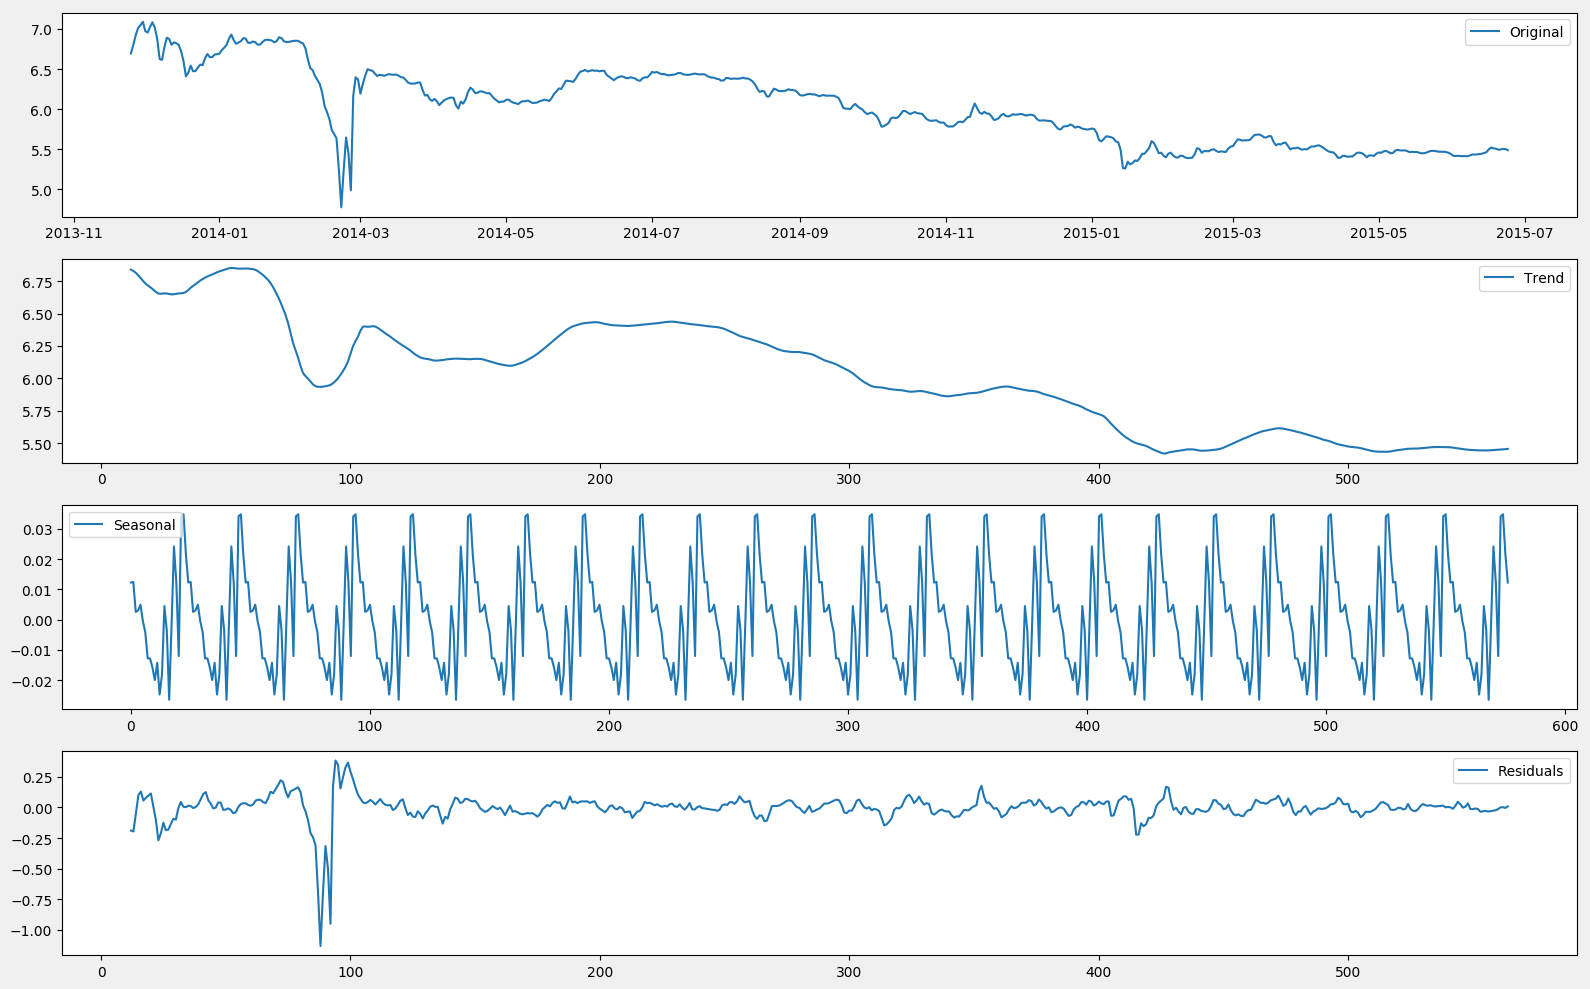

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize = (16,10))
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Weighted_Price.values, freq = 24)
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

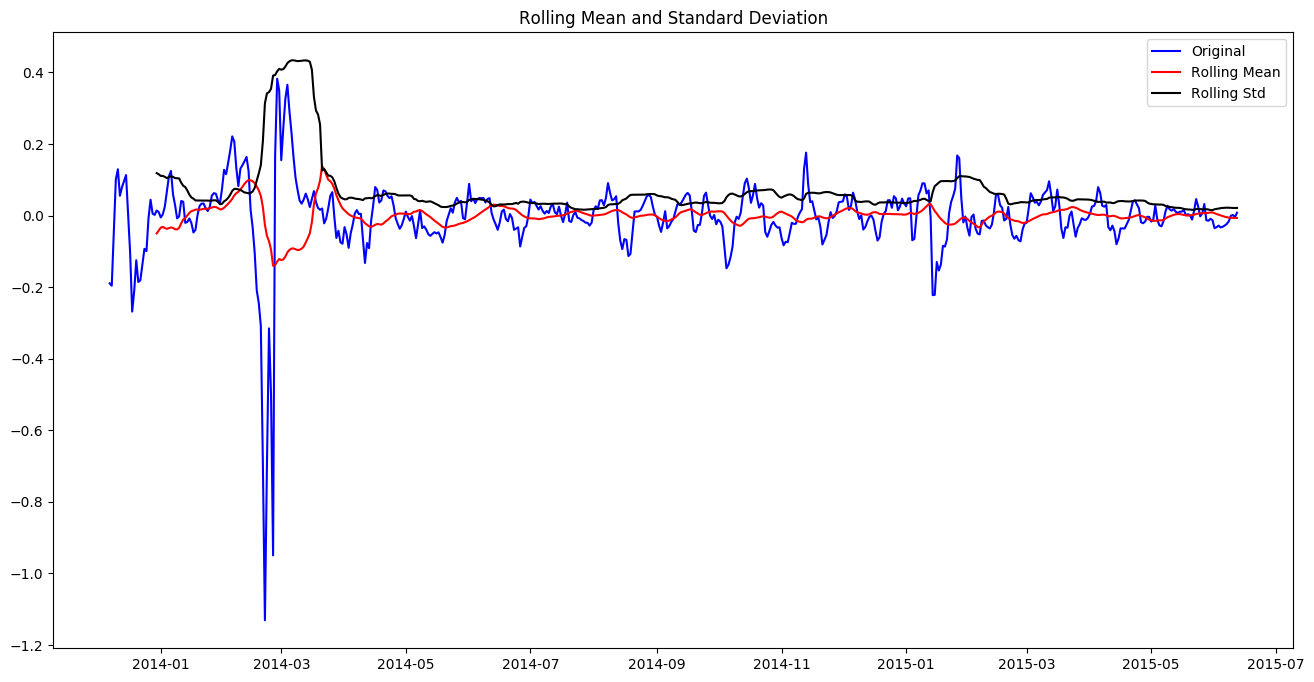

Results of Dickey Fuller test: 
Test Statistics               -1.046875e+01
p-value                        1.300860e-18
# Lag Used                     6.000000e+00
Number of Observations Used    5.460000e+02
Critical Value (1%)           -3.442384e+00
Critical Value (5%)           -2.866848e+00
Critical Value (10%)          -2.569597e+00
dtype: float64


In [94]:
plt.figure(figsize = (16,8))
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)
test_stationary(train_log_decompose[0])

In [95]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method= "ols")

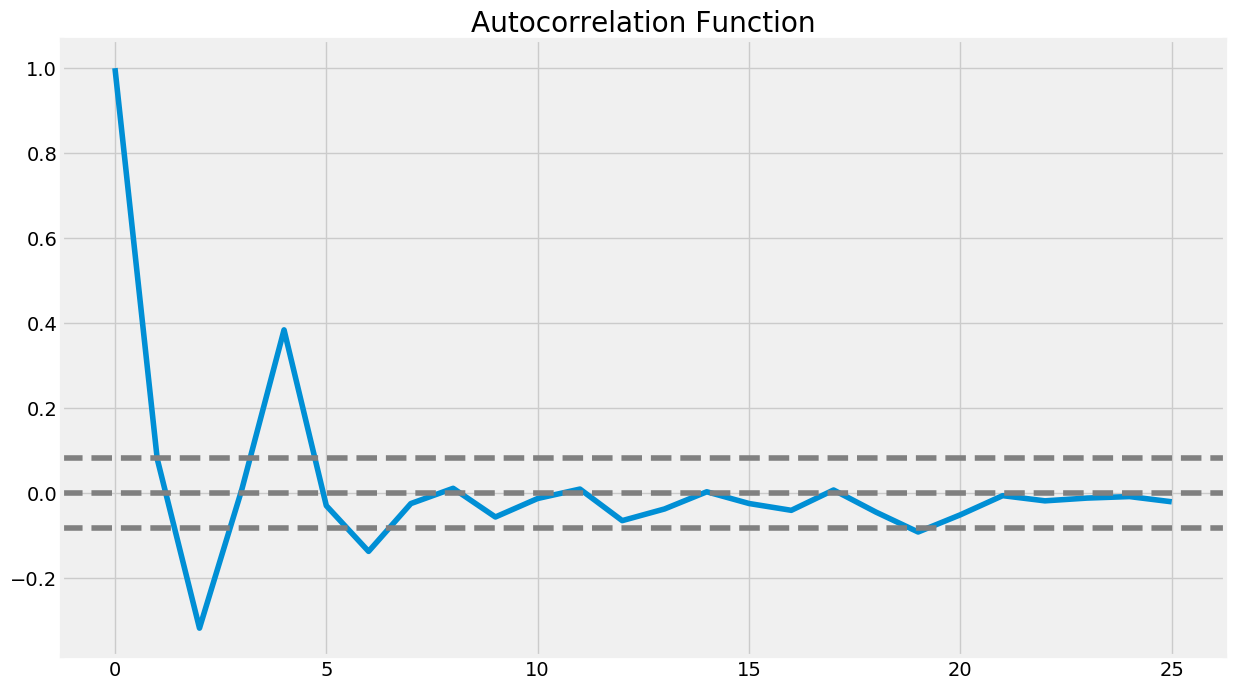

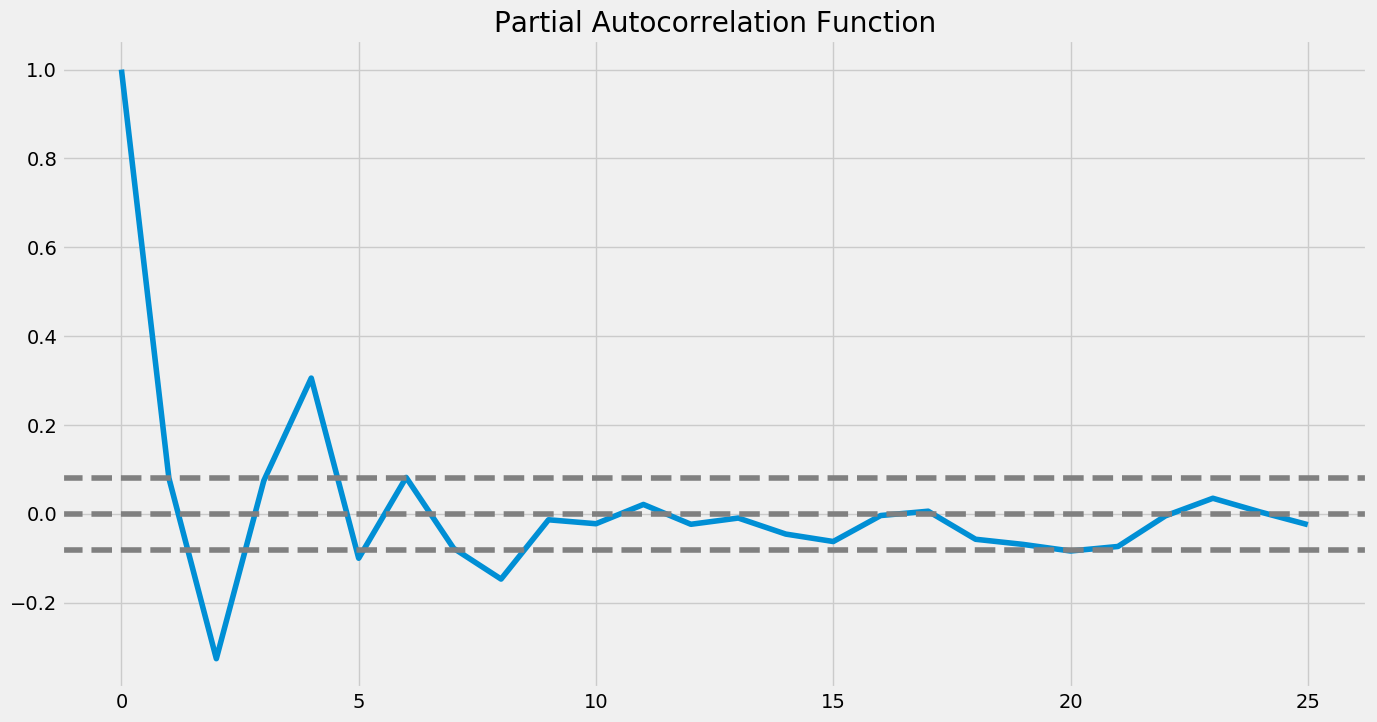

In [96]:
plt.figure(figsize = (15,8))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf)
plt.axhline( y = 0, linestyle = "--", color = "gray")
plt.axhline( y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline(y = 1.96 /np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Autocorrelation Function")
plt.show()
# PACF
plt.figure(figsize = (15,8))
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = "--", color = "gray")
plt.axhline(y = -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline( y = 1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Partial Autocorrelation Function")
plt.show()

/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


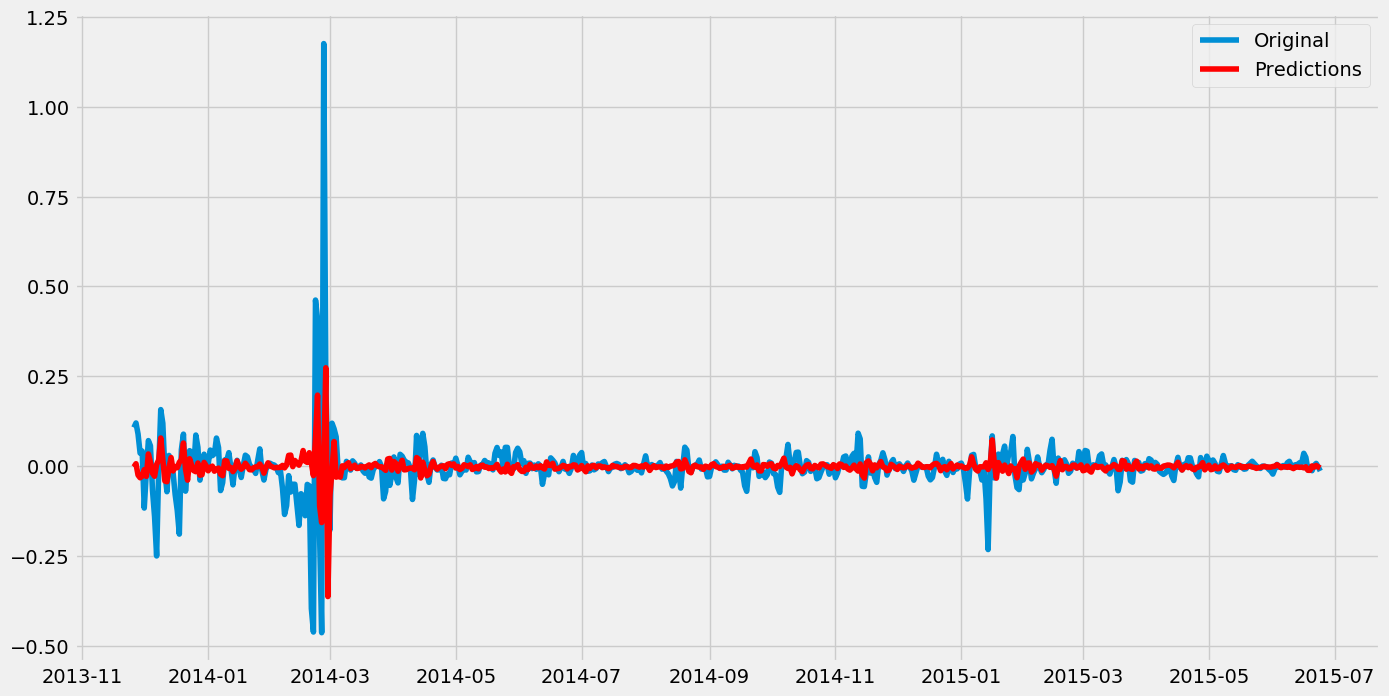

In [97]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize = (15,8))
model = ARIMA(Train_log, order = (2,1,0))  #here q value is zero since it is just AR Model
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')

In [100]:
AR_predict = results_AR.predict(start="2016-06-25", end="2016-09-25")
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0])* np.log(valid['Weighted_Price'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


ValueError: Length of passed values is 459, index implies 93

ValueError: shapes (552,) and (459,) not aligned: 552 (dim 0) != 459 (dim 0)

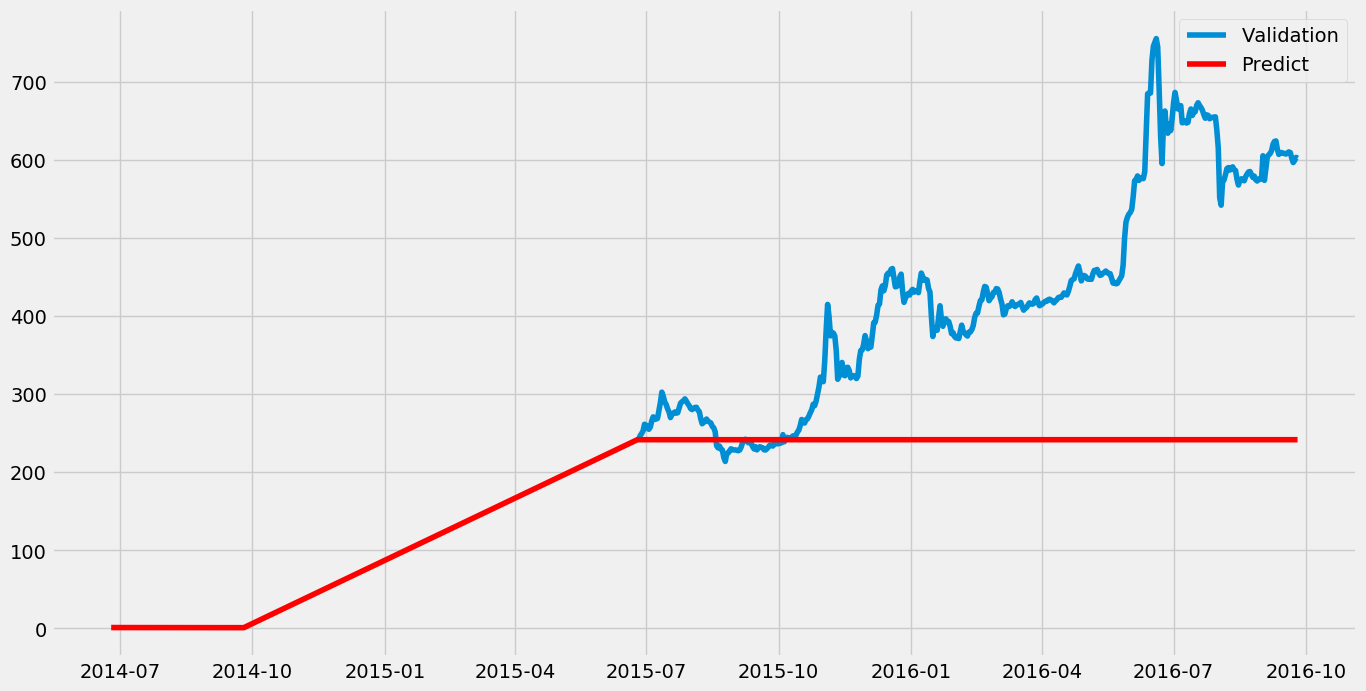

In [101]:
plt.figure(figsize = (15,8))
plt.plot(valid['Weighted_Price'], label = "Validation")
plt.plot(AR_predict, color = "red", label = "Predict")
plt.legend(loc = "best")
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Weighted_Price']))/valid.shape[0]))
plt.show()

In [ ]:
plt.figure(figsize = (15,8))
model = ARIMA(Train_log, order = (0,1,2)) # here the p value is 0 since it is moving average model
results_MA = model.fit(disp = -1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_MA.fittedvalues, color = "red", label = "Prediction")
plt.legend(loc = "best")

In [ ]:
MA_predict = results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Weighted_Price'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(valid['Weighted_Price'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Weighted_Price']))/valid.shape[0]))
plt.show()

In [ ]:
plt.figure(figsize = (16,8))
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Weighted_Price'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Weighted_Price'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Weighted_Price']))/given_set.shape[0]))
    plt.show()

In [ ]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['We'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Weighted_Price']))/given_set.shape[0]))
    plt.show()

In [ ]:
ARIMA_predict_diff=results_ARIMA.predict(start="2018-06-25", end="2018-09-25")

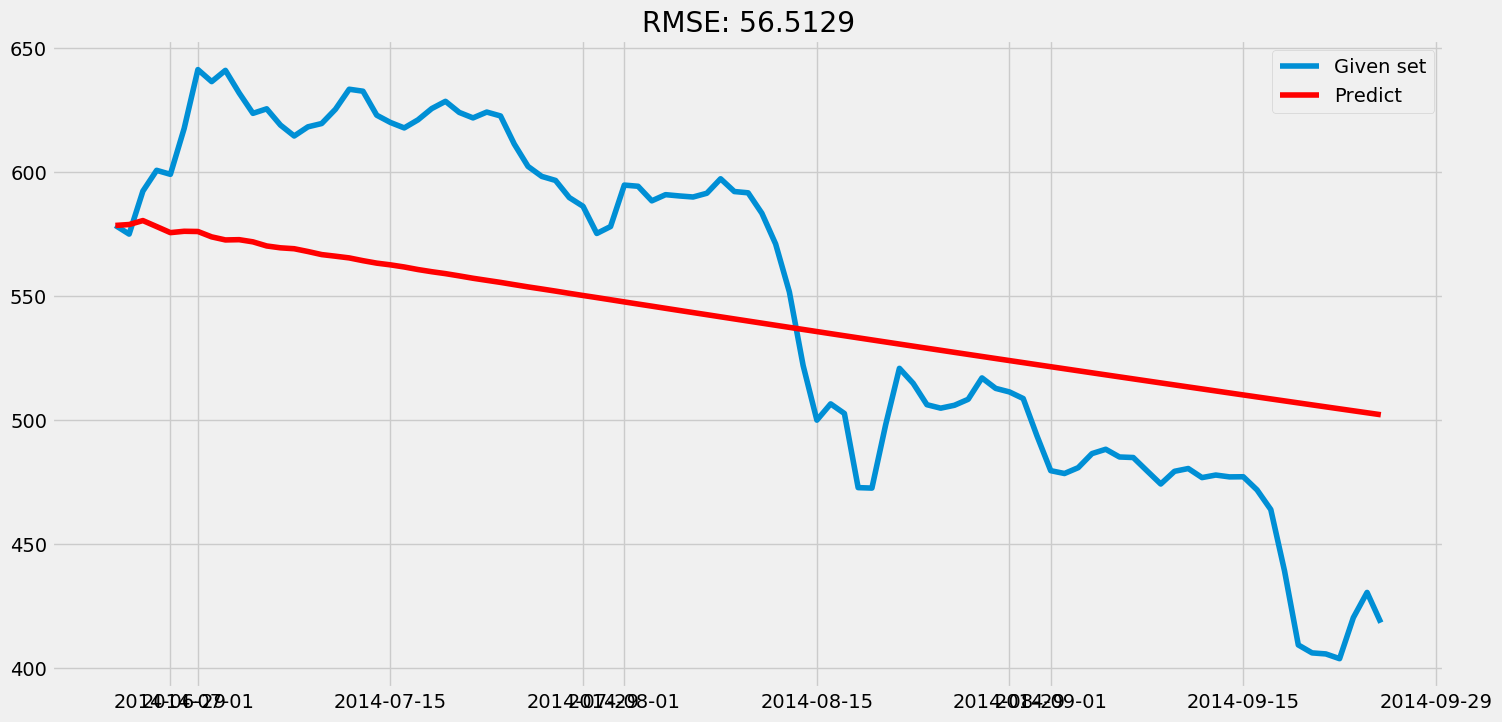

In [82]:
plt.figure(figsize = (16,8))
check_prediction_diff(ARIMA_predict_diff, valid)